# Searching for Optimal Portfolio Allocation using Modern Portfolio Theory

## 1. Introduction and Background

### 1.1 Modern Portfolio Theory (MPT)
Modern Portfolio Theory (MPT), introduced by Harry Markowitz in 1952, revolutionized the way investors approach portfolio management. MPT suggests that an investor can construct a portfolio that maximizes return for a given level of risk, or alternatively, minimizes risk for a given level of expected return. This is achieved through diversification, which reduces the overall risk of the portfolio by combining assets that are not perfectly correlated.

### 1.2 Importance of Portfolio Optimization
Portfolio optimization is crucial for both individual and institutional investors aiming to achieve their financial goals. By carefully selecting the asset allocation, investors can improve their risk-adjusted returns, ensuring that they are adequately compensated for the risk they are taking. The process involves selecting the appropriate mix of assets, calculating expected returns, assessing risks, and finding the optimal balance between risk and return.

### 1.3 Case Study Context
This paper presents a case study of optimizing a portfolio consisting of five assets: Large Cap US Stocks, Small Cap US Stocks, Gold, Short-Term Aggregate US Bonds and Long-Term Aggregate US Bonds. The analysis covers the period from 2007 to 2024, which includes significant market events such as the 2008 financial crisis, the subsequent recovery, the COVID-19 pandemic, and recent market fluctuations. The aim is to determine the optimal portfolio allocation using MPT and to analyze the performance of the optimized portfolios under different market conditions.

## 2. Data Collection

### 2.1 Data Sources
The daily price data for the five assets were obtained from Yahoo Finance. The data spans from April 110, 2007, to January 1, 2024, providing a comprehensive view of market behavior over a period of 17 years.

### 2.2 Time Period Justification
The chosen period includes a variety of market conditions, which makes the analysis robust and reflective of different economic environments. The 2008 financial crisis, for example, provides insights into portfolio performance during extreme market stress, while the subsequent recovery phase and the recent market trends offer a perspective on how portfolios adapt in different cycles.

### 2.3 Loading Data and Libraries

In [1]:
from tools.functions import eda_stats, corr_matrix_heatmap, daily_returns_dist_and_rolling_volatility, \
                            plot_volatility_and_returns, portfolio_analysis_dashboard, create_portfolio_weights, \
                            EfficientFrontier, get_stock_data, load_data

In [2]:
# get_stock_data(
#     ["SPY", "VB", "GLD", "BLV", "BSV"], 
#     ['long_bonds', 'short_bonds', 'gold', 'large_cap_stocks', 'small_cap_stocks'], 
#     "2007-04-10", "2024-01-01", 
#     filename="prices"
# )
prices, returns = load_data()

## 3. Descriptive Analysis

### 3.1 Statistical Summary
A statistical summary of the daily returns for each asset was generated, including metrics such as mean, standard deviation, skewness, and kurtosis. These statistics provide a basic understanding of the distribution of returns and the inherent risks associated with each asset.

In [3]:
eda_stats(returns)

-------------------------------------------
-- Statistics for Long Bonds
-------------------------------------------
Average annualized return: 0.05316105273483407
Annualized volatility (std): 0.1169325693070264
Skewness: -0.4694423267232255
Excess kurtosis: 6.154662107595112
Shapiro-Wilk test for normality
Null hypothesis of normality is rejected.

-------------------------------------------
-- Statistics for Short Bonds
-------------------------------------------
Average annualized return: 0.02308205048531775
Annualized volatility (std): 0.0306512201970129
Skewness: -1.0487982788703945
Excess kurtosis: 56.502029866806225
Shapiro-Wilk test for normality
Null hypothesis of normality is rejected.

-------------------------------------------
-- Statistics for Gold
-------------------------------------------
Average annualized return: 0.0809770962057701
Annualized volatility (std): 0.17466838543441734
Skewness: -0.09035069339716685
Excess kurtosis: 6.841652035932082
Shapiro-Wilk test for 

The analysis reveals that none of the assets returns follow a normal distribution, as evidenced by the rejection of the Shapiro-Wilk test for normality across all assets. This highlights the importance of considering non-normal risk measures and the potential for extreme events when constructing and optimizing portfolios, The highest kurtosis occured in Short-Term Bonds and Large Cap US Stocks, which indicates a higher risk of extreme outcomes.

We can obtain more detailed information regarding the distribution of daily returns by looking at the volatility analysis.

### 3.3 Volatility Analysis
Volatility was analyzed over the entire period, with a particular focus on periods of market stress. This involved calculating the rolling standard deviation of returns to capture changes in volatility over time. Understanding volatility patterns helps in constructing portfolios that can withstand different market conditions.

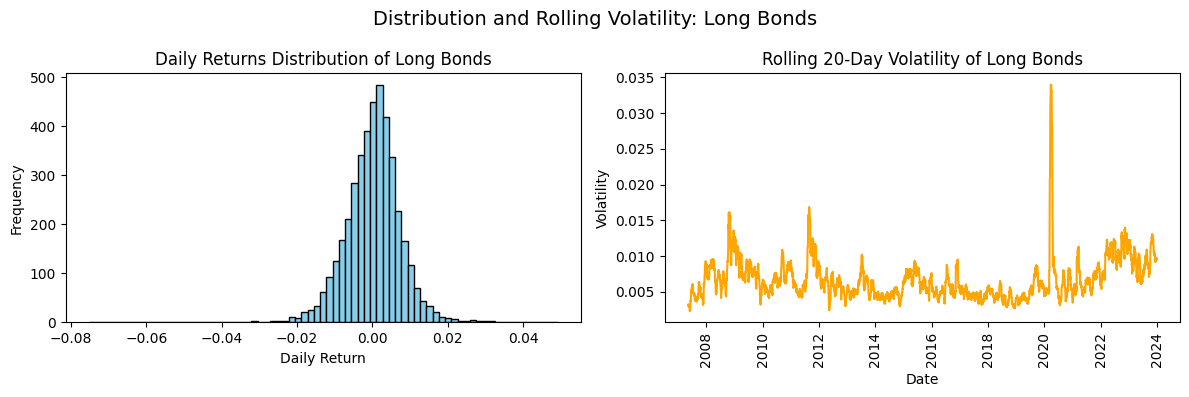

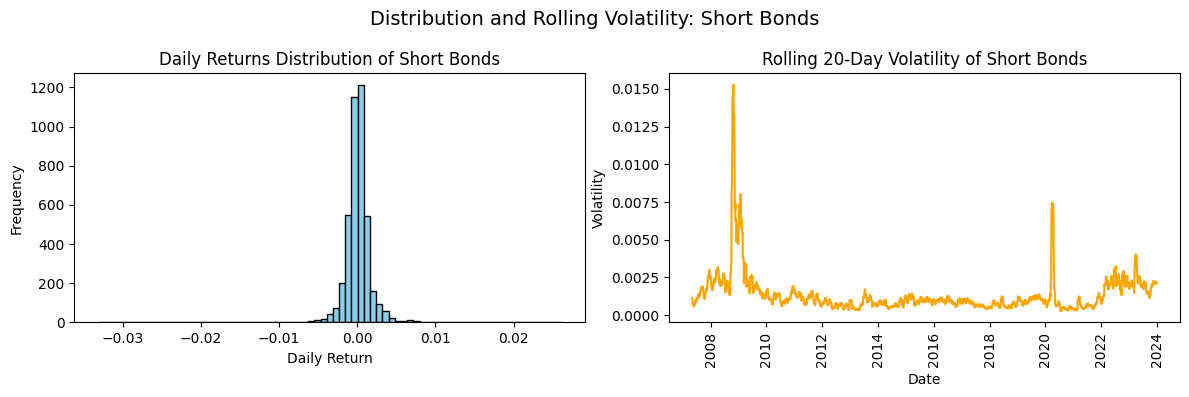

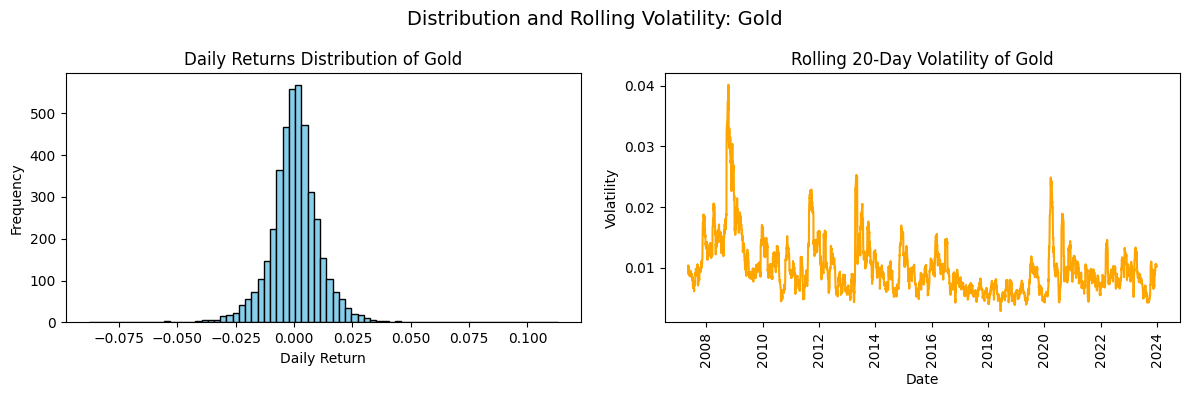

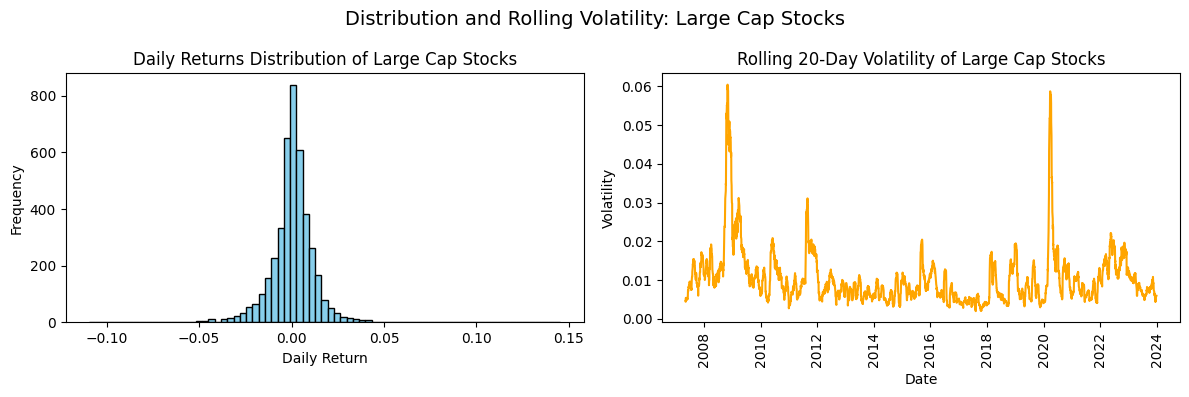

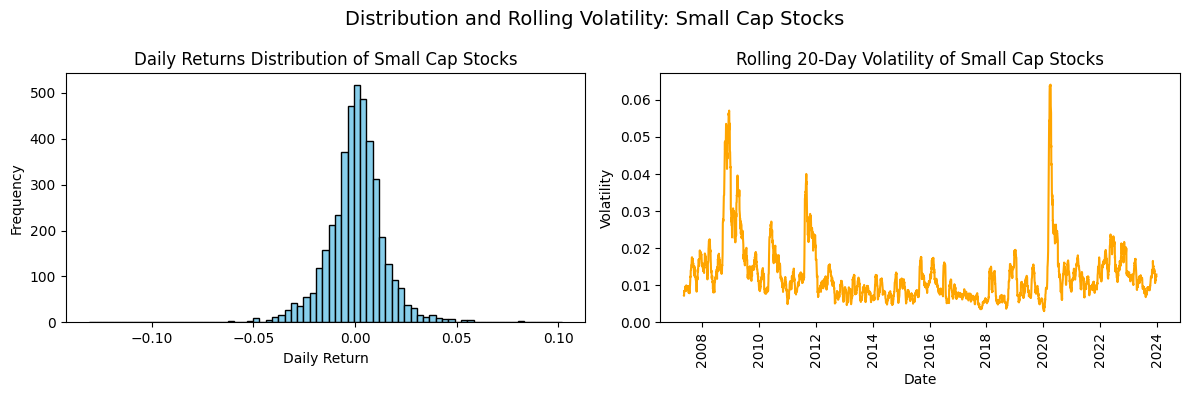

In [4]:
daily_returns_dist_and_rolling_volatility(returns)

As you can see, all distributions strongly resemble normal distributions, but previous tests rejected this possibility. The problem is the occurrence of so-called "*fat tails*", i.e. a disproportionately higher probability of extreme values than in the normal distribution.

As we know from the previous analysis, the highest kurtosis readings occurred in Large Cap US Stocks and Short-Term Bonds. On the distribution graph, you can see that in the case of Large Cap US Stocks there are indeed clear fat tails. In the case of Short-Term Bonds, on the other hand, the distribution is exceptionally slim, which means a high concentration of values around the mean. On the time series graph, you can see that for most of the period there is very low volatility on Short-Term Bonds, but during the crisis volatility increases as strongly as in the case of other assets, which causes a high kurtosis value.

For most assets, there was increased volatility during the 2008 and 2020 crises. Noteworthy exceptions are the lack of strongly increased volatility on Long-Term Bonds in 2008 and the lack of strongly increased volatility on gold in 2020. The most periods of increased volatility occurred in gold.

To look at the assets we are analyzing in a more general way, we can calculate the annualized volatility and return. 

The annualized volatility can be computed using:

$$
\sigma_{\text{annual}} = \text{std}(r_{\text{daily}}) \times \sqrt{252}
$$

where:
- $ \text{std}(r_{\text{daily}}) $ is the daily standard deviation of returns.
- $ \sqrt{252} $ is the square root of the number of trading days in a year, used to scale the daily volatility to an annual basis.

The multiplication by $ \sqrt{252} $ is based on the principle that the variance of returns scales linearly with time, and therefore, the standard deviation (volatility) scales with the square root of time.

The annualized expected return can be computed using:

$$
R_{\text{annual}} = \text{mean}(r_{\text{daily}}) \times 252
$$

where:
- $ \text{mean}(r_{\text{daily}}) $ is the average daily return.
- 252 is the number of trading days in a year, used to scale the daily return to an annual basis.

The multiplication by 252 scales the average daily return to reflect the total return expected over an entire year. This annualization assumes that returns are additive and that the average daily return will be realized consistently throughout the year.

This calculations assume that returns are independent and identically distributed over time.

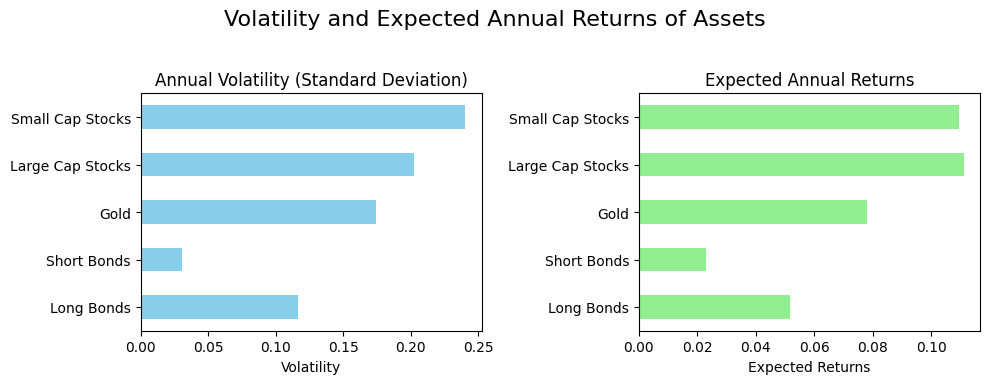

In [5]:
plot_volatility_and_returns(returns)

It can be seen that Short-Term Bonds have the lowest overall volatility. This also corresponds to the lowest expected return. In most assets, a pattern can be observed that the higher the volatility, the higher the expected return. An interesting relationship occurs in stocks, because despite the higher volatility of Small Cap US Stocks, the expected profit is higher on Large Cap US Stocks.

### 3.2 Correlation Analysis
The correlation matrix between the assets was calculated and visualized. This analysis is crucial for understanding the relationships between the assets and how they contribute to overall portfolio risk. For example, assets with low or negative correlations with each other can reduce portfolio risk through diversification.

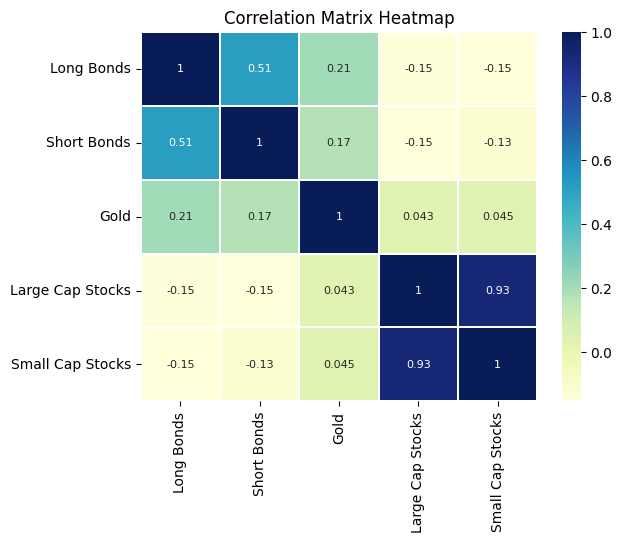

In [6]:
corr_matrix_heatmap(returns.corr())

We can see that equities (Small Cap US Stocks, Large Cap US Stocks) have a very high correlation with each other, and slight negative correlation to bonds. Fixed income assets (Long-Term Bonds, Short-Term Bonds) have a moderate correlation, and slight negative correlation to equities. Finally, gold has higher correlation to bonds than stocks.

## 5. Optimization Process of MPT

### Efficient Frontier Calculation

The **Efficient Frontier** is a fundamental concept in Modern Portfolio Theory (MPT) introduced by Harry Markowitz in 1952. It represents a graphical depiction of the optimal risk-return trade-offs available to investors when constructing portfolios.

#### Key Concepts:

1. **Definition**:
   - The Efficient Frontier is a curve on a plot where the x-axis represents portfolio risk (measured by standard deviation or volatility), and the y-axis represents portfolio return.
   - It shows the set of optimal portfolios that offer the highest expected return for a given level of risk or the lowest risk for a given level of return.

2. **Portfolios on the Efficient Frontier**:
   - Each point on the Efficient Frontier represents a portfolio with the highest expected return for a given level of risk.
   - Portfolios below the Efficient Frontier are considered sub-optimal as they do not offer the best possible return for their level of risk.
   - Portfolios above the Efficient Frontier are unattainable with the given assets.

3. **Risk-Return Trade-off**:
   - The Efficient Frontier illustrates the trade-off between risk and return. Investors aim to select portfolios on this frontier to achieve an optimal balance based on their risk tolerance and return expectations.

4. **Mean-Variance Optimization**:
   - **Objective**: Maximize expected returns for a given level of risk or minimize risk for a given level of return.
   - **Method**: Solve a quadratic optimization problem where the objective function is the portfolio variance (or standard deviation), subject to constraints on expected return and weights.
   - **Mathematical Formulation**:
     $$
     \text{Minimize } \sigma_p^2 = \mathbf{w}^T \mathbf{\Sigma} \mathbf{w}
     $$
     
     Subject to:
     $$
     \mathbf{w}^T \mathbf{r} \geq R_{\text{target}}
     $$
     $$
     \sum w_i = 1
     $$
     
     where $\mathbf{w}$ is the vector of portfolio weights, $\mathbf{\Sigma}$ is the covariance matrix of asset returns, and $\mathbf{r}$ is the vector of expected returns.

3. **Minimum Variance Portfolio**:
   - **Objective**: Find the portfolio with the lowest possible risk (variance).
   - **Method**: Solve the optimization problem with the goal of minimizing the portfolio variance.
   - **Mathematical Formulation**:
     $$
     \text{Minimize } \sigma_p^2
     $$
     
     Subject to:
     $$
     \sum w_i = 1
     $$

4. **Maximum Sharpe Ratio Portfolio**:
   - **Objective**: Maximize the Sharpe ratio, which is the ratio of excess return to portfolio risk.
   - **Method**: Optimize the portfolio weights to maximize the Sharpe ratio, which is calculated as:
     $$
     \text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
     $$
     
     where $R_p$ is the portfolio return, $R_f$ is the risk-free rate, and $\sigma_p$ is the portfolio standard deviation.

In the provided Python class `EfficientFrontier`, the theoretical concepts of portfolio optimization and the efficient frontier are applied to analyze and visualize portfolio performance. The code uses Modern Portfolio Theory (MPT) to evaluate various portfolio configurations based on their returns, volatility, and Sharpe ratio, enabling investors to make informed decisions about optimal asset allocation.

### Main Features:

* **Monte Carlo Simulation**:
   The algorythm simulates a set of portfolios by generating random weightings for each asset. Weights can be either zero or a minimal asset allocation specified by user. This random generation allows for the exploration of various portfolio combinations. For each portfolio, it computes the expected return, volatility, and Sharpe ratio. The **expected return** is calculated using the annualized mean returns of the assets, while **volatility** is derived from the annualized standard deviation of the portfolio's returns, which reflects the portfolio's risk.

* **Efficient Frontier**:
   The `ef_plot` method creates a scatter plot of these simulated portfolios, illustrating the trade-off between return and volatility. The plot highlights two key portfolios: the **Global Minimum Variance (GMV) portfolio**, which has the lowest possible volatility, and the **Maximum Sharpe Ratio (MSR) portfolio**, which offers the highest Sharpe ratio. The efficient frontier, formed by connecting the portfolios, represents the set of portfolios that offer the highest expected return for a given level of risk or the lowest risk for a given return.

* **Minimum Volatility Portfolio**:
   The `min_vol` method identifies the portfolio with the maximum return for a specified level of target volatility. By sorting the portfolios with volatility less than or equal to the target, it ensures that the chosen portfolio provides the best return for the given risk tolerance.

* **GMV and MSR Portfolios**:
   The `gmv` method finds the portfolio with the lowest volatility, which is crucial for risk-averse investors seeking minimal risk. Conversely, the `msr` method identifies the portfolio with the highest Sharpe ratio, which is valuable for investors seeking the most efficient risk-return trade-off.

Below, a simulation was performed on 10,000 portfolios, assuming a risk-free rate of 3%. Then, a graph of the efficient frontier was generated.

In [7]:
risk_free_rate = 0.03
num_portfolios = 100000
ef = EfficientFrontier(risk_free_rate, num_portfolios, returns, min_asset_allocation=0.025)

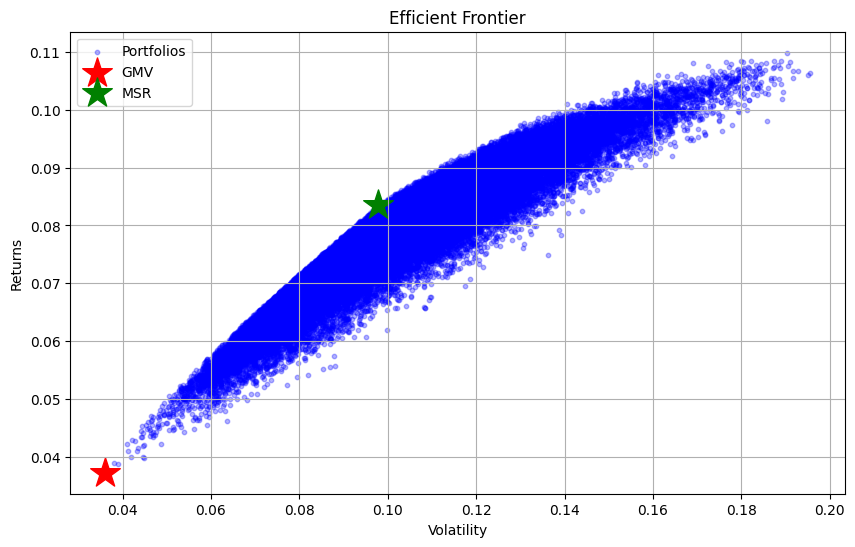

In [8]:
ef.ef_plot()

## 7. Performance Evaluation

Evaluating the performance of portfolios derived from Efficient Frontier analysis is essential to ensure that these portfolios meet investor objectives and align with desired risk-return profiles. The performance evaluation process typically involves assessing various metrics and characteristics to understand how well the portfolios perform compared to benchmarks and how they fit within the investor's risk tolerance and return expectations. Typical steps consist of:

#### 7.1. Comparison with Benchmarks

   - **Benchmark Index**: Compare the performance of portfolios against a relevant benchmark index (e.g., S&P 500 for equities, Bloomberg Barclays Aggregate Bond Index for fixed income). This helps assess whether the portfolios are providing adequate returns relative to a standard market index.
   - **Alpha and Beta**:
     - **Alpha** measures the portfolio's performance relative to its benchmark, adjusting for the risk taken. A positive alpha indicates outperformance compared to the benchmark.
     - **Beta** measures the portfolio's sensitivity to market movements. A beta greater than 1 suggests higher volatility compared to the market, while a beta less than 1 indicates lower volatility.

#### 7.2. Risk-Return Metrics

   - **Sharpe Ratio** measures the excess return per unit of risk.
     
   - **Sortino Ratio** similar to the Sharpe ratio but considers only downside risk (negative volatility). It is calculated as:
       
     $$
     \text{Sortino Ratio} = \frac{R_p - R_f}{\sigma_{d}}  
     $$
     
     where:
     - $\sigma_{d}$ is the standard deviation of negative returns. 
     
     
     This ratio is particularly useful when the downside risk is more relevant to the investor.

   - **Maximum Drawdown** measures the maximum peak-to-trough decline during a specific period. It indicates the largest loss from a peak to a subsequent trough. Lower maximum drawdowns are preferable as they represent less severe declines in portfolio value.

   - **Standard Deviation (Volatility)** measures the dispersion of portfolio returns. Higher volatility indicates higher risk. Comparing the portfolio’s volatility to its return helps assess the risk-adjusted performance. Computed as:
   
     $$
     \sigma_{\text{portfolio}} = \sqrt{\mathbf{w}^T \Sigma \mathbf{w}}
     $$
     
     where:
     - $ \mathbf{w} $ is the vector of portfolio weights.
     - $ \Sigma $ is the covariance matrix of asset returns.
     - $ \mathbf{w}^T $ is the transpose of the weights vector.
     
     This calculation determines the portfolio’s risk by evaluating how the returns of assets in the portfolio co-move with each other, using their covariances and the weights assigned to each asset. By squaring the weighted sum of covariances and taking the square root, the volatility of the portfolio is assessed, which provides a measure of how much the portfolio’s returns are expected to fluctuate.

#### 7.3. Return Metrics

   - **Cumulative Returns** tracks the total return over a period, including compounding. Comparing cumulative returns to benchmarks provides insight into overall performance.

   - **Annualized Return** measures the average annual return over a period, adjusted for compounding. It provides a standardized measure of return performance.

   - **Compound Annual Growth Rate (CAGR)** represents the annual growth rate of an investment over time, assuming reinvestment of earnings. Computed as: 
     
     $$
     \text{CAGR} = \left( \frac{C_{\text{final}}}{C_0} \right)^{\frac{1}{N}} - 1
     $$
     
     where:
     - $ C_{\text{final}} $ is the final cumulative return, calculated as $ C_t = \prod_{i=1}^{t} (1 + r_{\text{portfolio}, i}) $, where $ r_{\text{portfolio}, i} $ is the daily return on day $ i $
     - $ C_0 $ is the initial value of the investment, which is 1 if starting from an initial value of 100% or 1.0.
     - $ N $ is the number of years.


     The CAGR provides a smoothed annual growth rate, assuming the investment grows at a consistent rate over time.

By evaluating portfolios using these metrics, investors can gain a comprehensive understanding of their performance, risk characteristics, and alignment with investment objectives. This thorough analysis ensures that the portfolios derived from the Efficient Frontier analysis not only meet theoretical optimality but also perform effectively in practical scenarios.

#### 7.4 Portfolio Analysis Dashboard

In this study, a comprehensive analytical tool was created to evaluate portfolio performance through a multi-faceted approach. The tool accepts a DataFrame containing daily returns for a set of analyzed assets, along with a corresponding set of asset weights, to generate a detailed analysis of portfolio behavior. The output includes four key visualizations: a portfolio allocation pie chart that visually represents the distribution of investments across various assets, a cumulative returns time series chart that compares the portfolio's performance against a benchmark index (either S&P 500 or 60/40 portfolio), a daily drawdown chart that highlights the magnitude of declines from peak values over time and a summary table with all portfolio statistics described above.

This set of metrics offers a robust framework for assessing portfolio risk and return characteristics in alignment with Modern Portfolio Theory (MPT) and enables a thorough examination of the portfolio's efficiency, resilience, and alignment with investment goals.

To demonstrate how the tool works, dashboards for four portfolios have been generated below:
* Global Minimum Variance portfolio
* Maximum Sharpe Ratio portfolio
* Optimal portfolio for a given volatility of 8%
* Equal weighted portfolio

The classic 60/40 portfolio was used as a benchmark.

In [9]:
benchmark='S&P500'

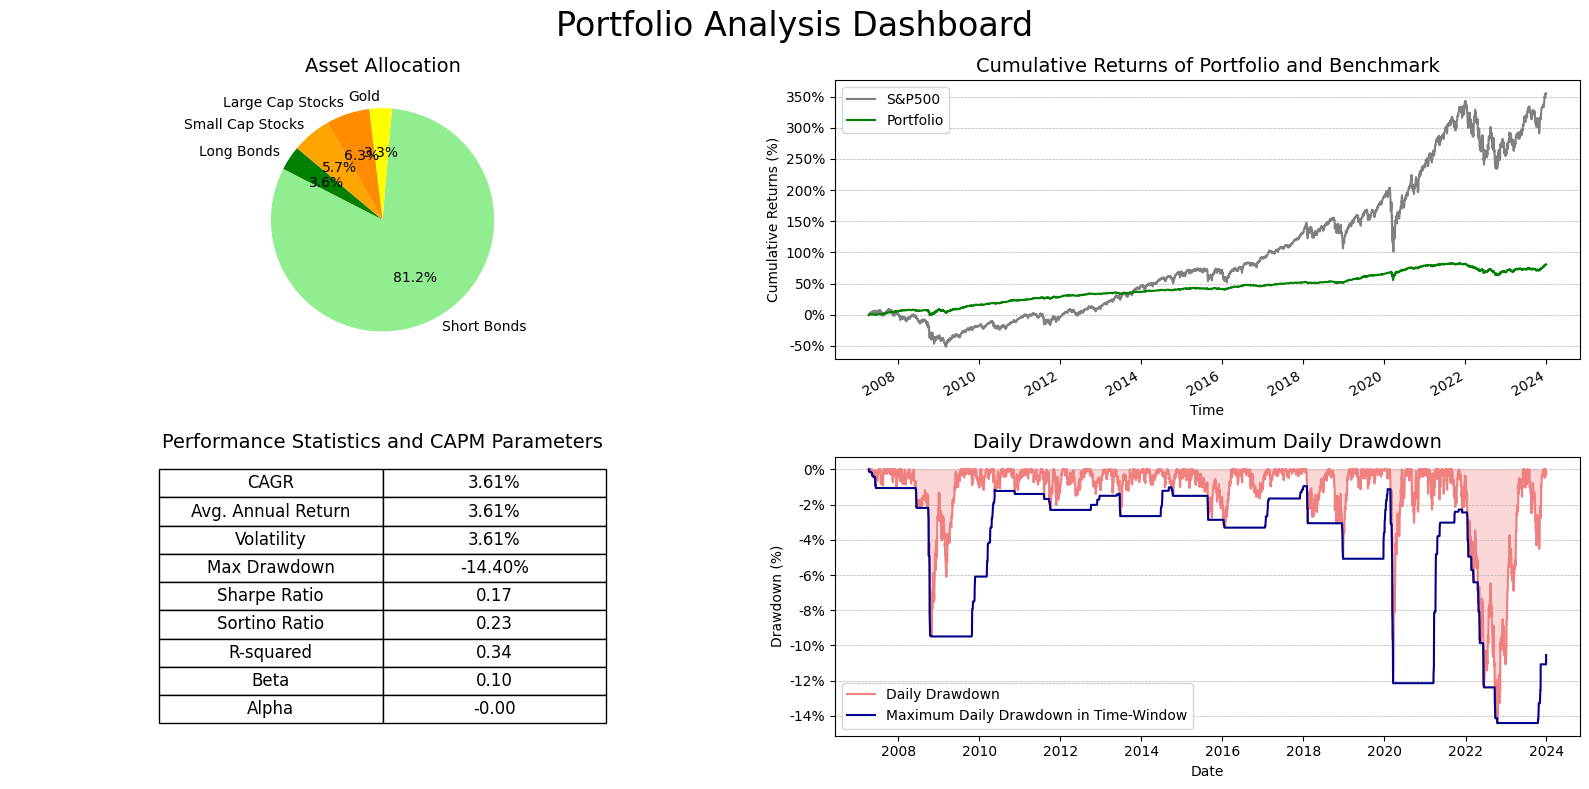

In [10]:
# Global Minimum Variance portfolio
pf_weights = ef.gmv()
portfolio_analysis_dashboard(prices, pf_weights, returns, [weights for weights in pf_weights], benchmark, risk_free_rate, window=252)

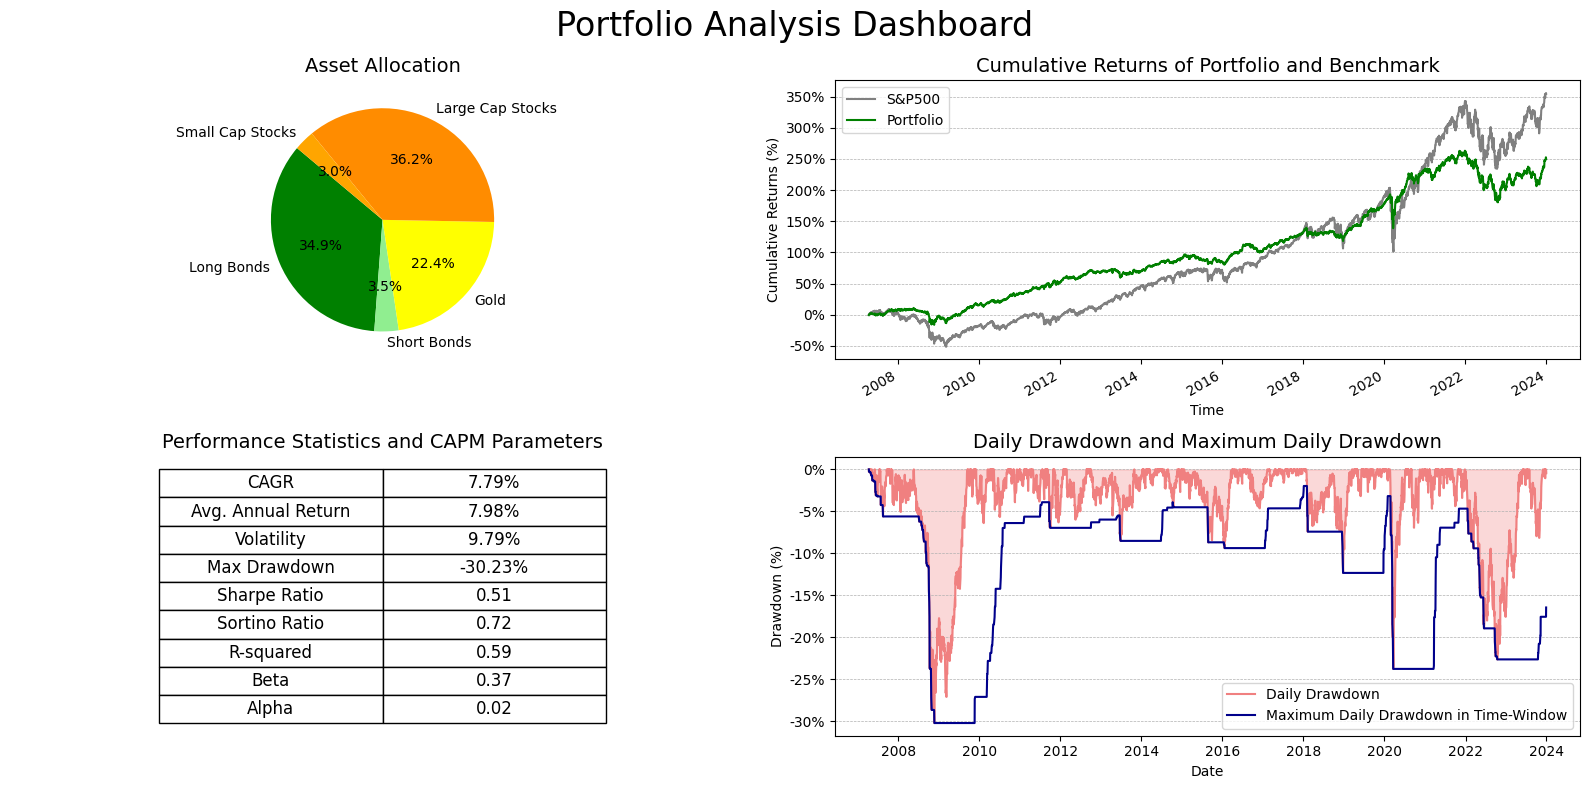

In [11]:
# Maximum Sharpe Ratio portfolio
pf_weights = ef.msr()
portfolio_analysis_dashboard(prices, pf_weights, returns, [weights for weights in pf_weights], benchmark, risk_free_rate, window=252)

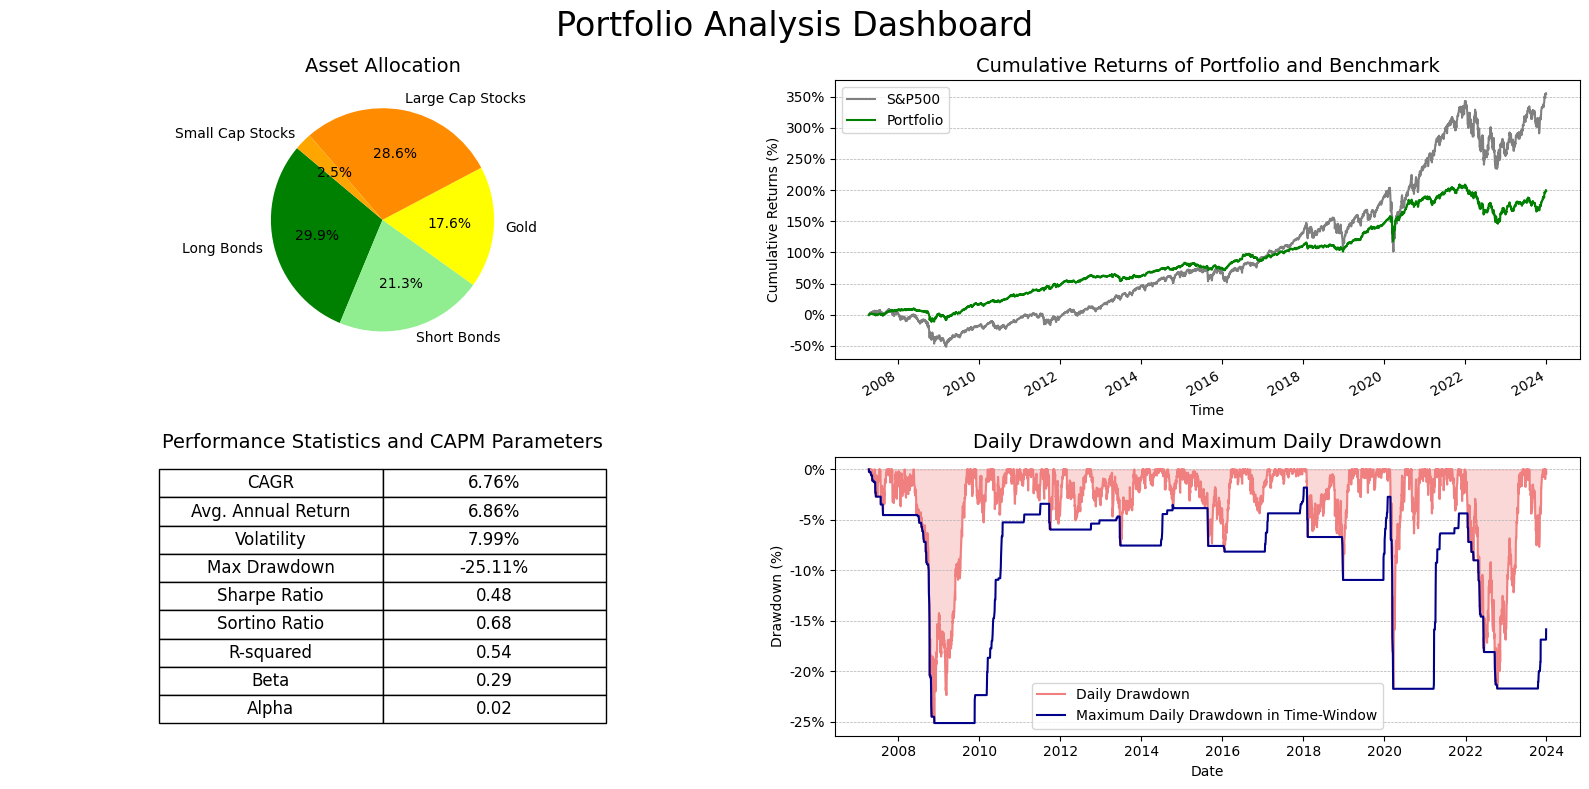

In [12]:
# Optimal portfolio for a given volatility of 8%
pf_weights = ef.min_vol(0.08)
portfolio_analysis_dashboard(prices, pf_weights, returns, [weights for weights in pf_weights], benchmark, risk_free_rate, window=252)

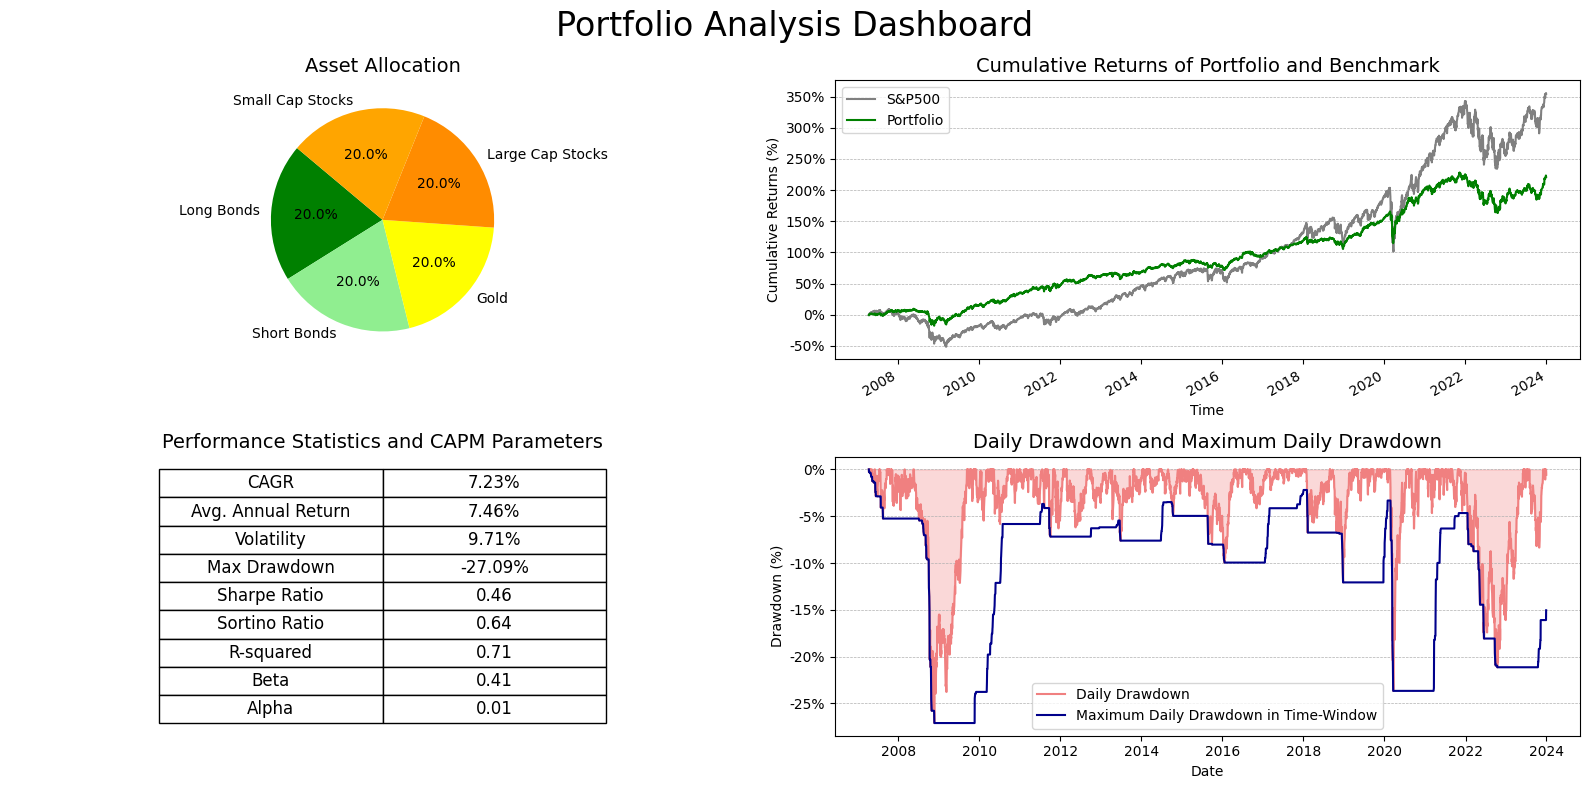

In [13]:
# Equal weighted portfolio
pf_weights = create_portfolio_weights(returns, [0.2, 0.2, 0.2, 0.2, 0.2])
portfolio_analysis_dashboard(prices, pf_weights, returns, [weights for weights in pf_weights], benchmark, risk_free_rate, window=252)

## TODO

* poprawić wyliczanie alphy, bo nie wygląda jakby było dobrze, spróbować zaimplementować tak jak było w kursie

* poprawić max drawdown w tabelce ze statystykami, bo nie zgadza się z wykresem

* uprościć algorytm tak aby nie wyliczać kilka razy tego samego, standaryzacja i przejrzystość

### Przyszłość

* dodac do procesu ewaluacji CAPM z kursu i te Fama French, bo to chyba było własnie po to, żeby porównywać

* umożliwić porównanie kilku portfolio ze sobą (w takiej formie, że tworzę customowy benchmark, ale nadal wybieram któreś portfolio jako główne, bo inaczej by trzeba było dużo zmieniać)

* dodać jakoś risk-free asset jako część portfela, bo tak się chyba robiło, że dodajesz jeszcze cash jako ostatni element w symulacji i wtedy otrzymujesz też info ile kapitału opłaca się inwestować
  - to by musiało być risk-free rate / 252 jako daily return i dodany do returns jako kolumna
  
* porobić testy w innym przedziale czasowym, np. bez covida, albo bez obu kryzysów